In [15]:
import csv
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import torch.optim as optim
from torch import nn 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Importing

In [16]:
data = []

with open('almonds/Almond.csv', 'r') as dataset:
    reader = csv.reader(dataset)

    headers = [re.sub(r'\s*\(.*\)','',header).strip() for header in next(reader)[1:]]
    types = []

    for line in reader:
        row = {}
        for x, value in enumerate(line[1:]):
            if x < len(headers) - 1:
                row[headers[x]] = float(value) if value != '' else None
            else:
                if value not in types:
                    types.append(value)
                row[headers[x]] = types.index(value) if value != '' else None
        data.append(row)

### Preprocessing

In [17]:
nones = defaultdict(int)

for instance in data:
    for feature, value in instance.items():
        if value == None:
            nones[feature] += 1

lengths = [instance['Length'] for instance in data]
widths = [instance['Width'] for instance in data]
thicknesses = [instance['Thickness'] for instance in data]

ratios = [instance['Length'] / instance['Width'] for instance in data if instance['Length'] is not None and instance['Width'] is not None]
median_ratio = np.median(ratios)

thickness_median = np.median([value for value in thicknesses if value is not None])

for instance in data:
    if instance['Length'] is None:
        instance['Length'] = instance['Width'] * median_ratio      
    elif instance['Width'] is None:
        instance['Width'] = instance['Length'] / median_ratio
    elif instance['Thickness'] is None:
        instance['Thickness'] = thickness_median
        
    if instance['Roundness'] is None: 
        instance['Roundness'] = 4 * instance['Area'] / (np.pi * instance['Length'] ** 2)
    if instance['Aspect Ratio'] is None: 
        instance['Aspect Ratio'] = instance['Length'] / instance['Width']
    if instance['Eccentricity'] is None:
        instance['Eccentricity'] = np.sqrt(1 - (instance['Width'] / instance['Length'])**2)


### Setup of NN using PyTorch

Learning rate: 0.001, Hidden units: 64
Accuracy: 75.69% and STD: 0.02
Learning rate: 0.001, Hidden units: 96
Accuracy: 75.48% and STD: 0.02
Learning rate: 0.001, Hidden units: 128
Accuracy: 77.93% and STD: 0.02
Learning rate: 0.001, Hidden units: 160
Accuracy: 80.43% and STD: 0.01
Learning rate: 0.001, Hidden units: 192
Accuracy: 81.09% and STD: 0.02
Learning rate: 0.001, Hidden units: 224
Accuracy: 81.19% and STD: 0.01
Learning rate: 0.001, Hidden units: 256
Accuracy: 81.14% and STD: 0.02
Learning rate: 0.001, Hidden units: 288
Accuracy: 79.92% and STD: 0.01
Learning rate: 0.001, Hidden units: 320
Accuracy: 81.24% and STD: 0.01
Learning rate: 0.001, Hidden units: 352
Accuracy: 81.34% and STD: 0.02
Learning rate: 0.001, Hidden units: 384
Accuracy: 80.84% and STD: 0.02
Learning rate: 0.001, Hidden units: 416
Accuracy: 81.91% and STD: 0.01
Learning rate: 0.001, Hidden units: 448
Accuracy: 81.40% and STD: 0.01
Learning rate: 0.001, Hidden units: 480
Accuracy: 81.75% and STD: 0.02
Learning

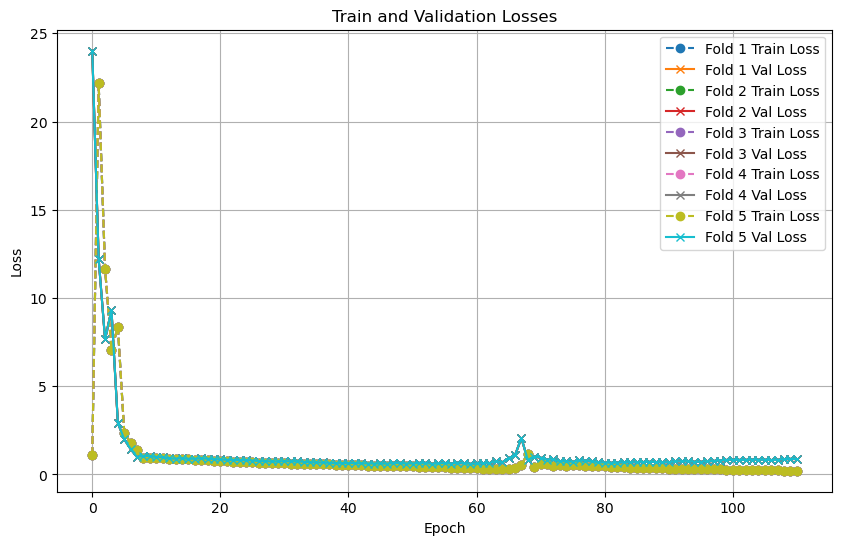

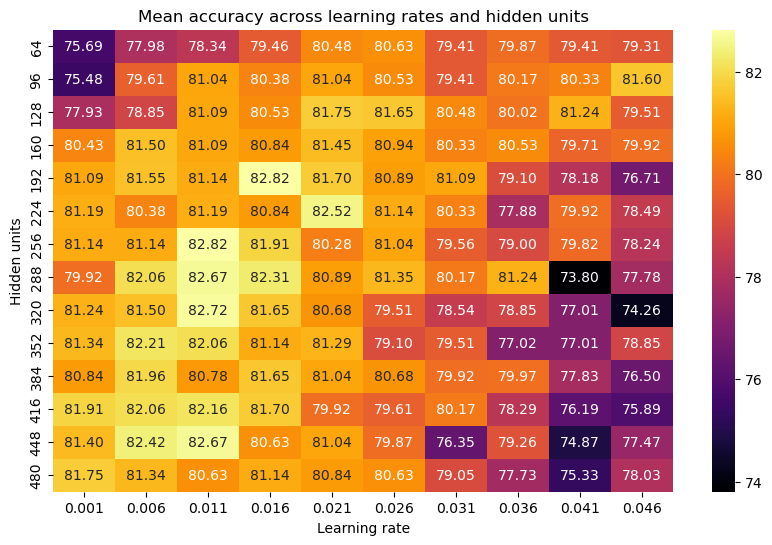

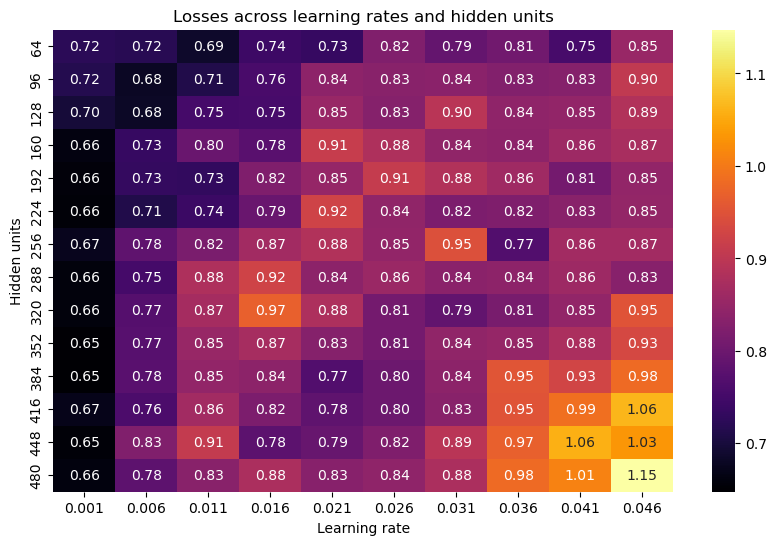

Test accuracy: 80.76%
Precision: 0.80
Recall: 0.80
F1: 0.80
Test loss: 1.3090


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = headers[:-1]
target = headers[-1]

X = [[instance[feature] for feature in features] for instance in data]
y = [instance[target] for instance in data]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=97)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=97)

#optional
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.cpu()), dtype=torch.float32).to(device)
X_val = torch.tensor(scaler.transform(X_val.cpu()), dtype=torch.float32).to(device)
X_test = torch.tensor(scaler.transform(X_test.cpu()), dtype=torch.float32).to(device)

class AlmondNN(nn.Module):
    def __init__(self, hidden_units):
        super(AlmondNN, self).__init__()
        self.fc1 = nn.Linear(len(features), hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.fc3 = nn.Linear(hidden_units // 2, hidden_units // 4)
        self.fc4 = nn.Linear(hidden_units // 4, len(types))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x 
    
lrs = np.arange(0.001, 0.05, 0.005)
hidden_range = np.arange(64, 512, 32)
epochs = 500

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=97)

highest_mean_acc, lowest_std_acc = 0, float('inf') 
lowest_loss = float('inf')
acc_lr, acc_h, std_lr, std_h = None, None, None, None

for lr, hidden in itertools.product(lrs, hidden_range):
    lr = round(lr, 4)
    accuracies = []
    train_losses = []
    val_losses = []
    print(f'Learning rate: {lr}, Hidden units: {hidden}')
    criterion = nn.CrossEntropyLoss()

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        model = AlmondNN(hidden).to(device)
        optimser = optim.Adam(model.parameters(), lr=lr)

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        best_accuracy = 0
        patience_count = 0
        patience = 50

        fold_train_losses = []
        fold_val_losses = []

        for epoch in range(epochs):
            model.train()
            optimser.zero_grad()

            outputs = model(X_train_fold)
            train_loss = criterion(outputs, y_train_fold)
            train_loss.backward()
            optimser.step()

            fold_train_losses.append(train_loss.item())

            model.eval()

            with torch.no_grad():
                outputs = model(X_val_fold)
                val_loss = criterion(outputs, y_val_fold)
                _, predicted = torch.max(outputs, 1)

                accuracy = (predicted == y_val_fold).sum().item() / len(y_val_fold)

            fold_val_losses.append(val_loss.item())

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                patience_count = 0
            else:
                patience_count += 1

            if patience_count >= patience:
                break

        accuracies.append(best_accuracy)
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)

        # plt.figure()
        # plt.plot(range(len(fold_train_losses)), fold_train_losses, label=f'Fold {fold+1} Train Loss')
        # plt.plot(range(len(fold_val_losses)), fold_val_losses, label=f'Fold {fold+1} Val Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title(f'Fold {fold+1} Train and Validation Losses')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
    
    accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    loss = np.mean(np.concatenate(val_losses))

    if accuracy > highest_mean_acc:
        highest_mean_acc = accuracy
        acc_lr, acc_h = lr, hidden
    if std_accuracy < lowest_std_acc:
        lowest_std_acc = std_accuracy
        std_lr, std_h = lr, hidden

    if loss < lowest_loss:
        lowest_loss = loss
        loss_lr, loss_h = lr, hidden

    print(f'Accuracy: {accuracy * 100:.2f}% and STD: {std_accuracy:.2f}')
    results.append({
        'lr': lr,
        'epochs': epochs,
        'hidden units': hidden,
        'mean accuracy': accuracy * 100,
        'mean loss': loss,
        'standard dev accuracy' : std_accuracy
    })

print(f'Best accuracy {highest_mean_acc * 100:.2f} with learning rate of {acc_lr} and hidden units of {acc_h}')
print(f'Best std {lowest_std_acc:.2f} with learning rate of {std_lr} and hidden units of {std_h}')
print(f'Best loss {lowest_loss} with learning rate of {loss_lr} and hidden units of {loss_h}')

results = pd.DataFrame(results)

# plt.figure(figsize=(10,6))
# for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
#     plt.plot(range(len(fold_train_losses)), fold_train_losses, label=f'Fold {fold + 1} Train Loss', linestyle='--', marker='o')
#     plt.plot(range(len(fold_val_losses)), fold_val_losses, label=f'Fold {fold + 1} Val Loss', linestyle='-', marker='x')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Losses')
# plt.legend()
# plt.grid(True)
# plt.show()

pivot_mean = results.pivot_table(index='hidden units', columns='lr', values='mean accuracy')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_mean, annot=True, cmap='inferno', fmt='.2f')
plt.title('Mean accuracy across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

pivot_std = results.pivot_table(index='hidden units', columns='lr', values='mean loss')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_std, annot=True, cmap='inferno', fmt='.2f')
plt.title('Losses across learning rates and hidden units')
plt.xlabel('Learning rate')
plt.ylabel('Hidden units')
plt.show()

model = AlmondNN(acc_h).to(device)
optimser = optim.Adam(model.parameters(), lr=acc_lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    optimser.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimser.step()

model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)

print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
print(f'Recall: {recall_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
print(f'F1: {f1_score(y_test.cpu(), predicted.cpu(), average="macro"):.2f}')
test_loss = criterion(outputs, y_test).item()
print(f'Test loss: {test_loss:.4f}')